In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import calinski_harabaz_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import sys
from gmvae_model import GMVAE
from utils import *

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
k = 2
n_x = 10
n_z = 2

# Load dataset

In [3]:
true_clusters = 3
dataset = load_and_mix_data('generated_from_cluster',true_clusters,True)
print(dataset.train.data.shape)

(1350, 10)


# Create model

In [4]:
model = GMVAE(k=k, n_x=n_x, n_z=n_z)

graph written


In [5]:
def sample_z(sess, X, model, multiplier, k, n_z):
    '''
        Given examples data, computes their latent variables
    '''
    M = len(X)
    all_z = np.zeros((M*multiplier, k, n_z))
    for i in range(k):
        for j in range(multiplier):
            all_z[M*j:M*(j+1), i] = sess.run(model.z[i],
                                    feed_dict={'x:0': X})

    qy = sess.run(model.qy, feed_dict={'x:0': X})
    category = qy.argmax(axis=1)
    category = np.concatenate([category for j in range(multiplier)])
    y_pred = one_hot(category, depth=k).astype(bool)

    z = all_z[y_pred]
    return z, category

In [6]:
def pca(X, n_z):
    pca_solver = PCA(n_components = n_z)
    x = pca_solver.fit_transform(X)
    return x

In [7]:
def gm(X, k):
    gm_solver = GaussianMixture(n_components = k)
    gm_solver.fit(X)
    labels = gm_solver.predict(X)
    return labels

In [8]:
def perform_pca_and_cluster(X, k, n_z):
    X_reducted = pca(X, n_z)
    X_labels = gm(X_reducted, k)
    return X_reducted, X_labels

In [9]:
def compute_pairwise_stability(sess, model, X, k, n_z):
    X_reducted, X_labels = perform_pca_and_cluster(X, k, n_z)
    z, category = sample_z(sess,
                           X,
                           model,
                           multiplier = 1, 
                           k = k, 
                           n_z = n_z)
    total_pairs = 0
    stable_pairs = 0
    for i in range(len(category)):
        for j in range(i,len(category)):
            if category[i] == category[j]:
                total_pairs += 1
                if X_labels[i] == X_labels[j]:
                    stable_pairs += 1
    return 1.*stable_pairs/total_pairs

In [122]:
def sample_and_compute_calinski_harabaz(sess, X, model, multiplier, k, n_z):
    z, categories = sample_z(sess,
                           X,
                           model,
                           multiplier,
                           k,
                           n_z)
    if np.unique(categories).shape[0] == 1:
        print('All variables assigned to one cluster! Returning a score of 0.')
        return np.zeros(multiplier)
    output = np.zeros(multiplier)
    M = X.shape[0]
    for i in range(multiplier):
        output[i] = calinski_harabaz_score(z[M*i:M*(i+1)], categories[M*i:M*(i+1)])
    return output
    return calinski_harabaz_score(z,categories)

graph written
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.93e-01,  1.82e+00,  6.93e-01,  1.85e+00,  5.60e-01,         1
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.93e-01,  1.81e+00,  6.93e-01,  1.77e+00,  4.07e-01,         2
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  6.93e-01,  1.79e+00,  6.93e-01,  1.77e+00,  3.87e-01,         3
graph written
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.10e+00,  1.40e+00,  1.10e+00,  1.39e+00,  3.80e-01,         1
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.10e+00,  1.46e+00,  1.10e+00,  1.36e+00,  3.53e-01,         2
    tr_ent,   tr_loss,     t_ent,    t_loss,     t_acc,     epoch                                   
  1.10e+00,  1.43e+00,  1.10e+00,  1

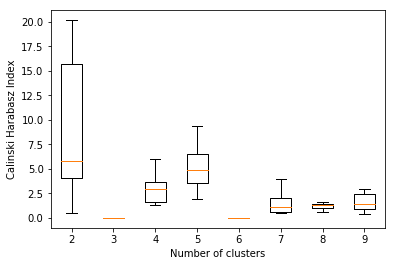

In [129]:
saver = tf.train.Saver(keep_checkpoint_every_n_hours=4)
CH_scores = []
stability_scores = []
clusters = range(2,10)
for k in clusters:
    model = GMVAE(k=k, n_x=n_x, n_z=n_z)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        # TRAINING
        sess_info = (sess, saver)
        # For some reason we can't save when running on jupyter notebook
        history = model.train('logs/gmvae_k={:d}.log'.format(k), dataset, sess_info, epochs=3, save_parameters = False)

        multiplier = 10 # How many z:s we sample from one data point
        CH = sample_and_compute_calinski_harabaz(sess,
                               dataset.test.data,
                               model,
                               multiplier,
                               k,
                               n_z)
        CH_scores.append(CH)
        stability_score = compute_pairwise_stability(sess, model, dataset.test.data, k, n_z)
        stability_scores.append(stability_score)
        
print(CH_scores)
print(stability_scores)
box_plot(CH_scores, clusters)

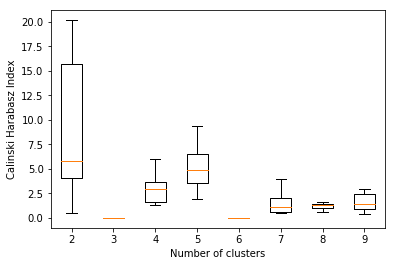

In [131]:
def box_plot(scores, clusters):
    K = len(scores)
    plt.figure()
    plt.xlabel('Number of clusters')
    plt.ylabel('Calinski Harabasz Index')
    plt.boxplot(scores, sym = '', positions = clusters)
    plt.show()
box_plot(CH_scores, clusters)

(10,)
(10,)
(10,)
(10,)


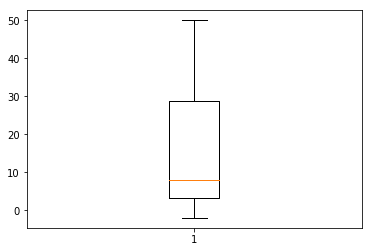

In [92]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1)

# fake up some data
spread = np.random.rand(10) * 100
print(spread.shape)
center = np.ones(10) * 50
print(center.shape)
flier_high = np.random.rand(10) * 100 + 100
print(flier_high.shape)
flier_low = np.random.rand(10) * -100
print(flier_low.shape)
data = np.concatenate((spread, center, flier_high, flier_low), 0)

# don't show outlier points
plt.figure()
plt.boxplot([-2,2,3,4,5,11,25,30,50,50],0,'')

plt.show()